<h1 style="text-align: center;"><b>Neural Network for Faces Classification</b></h1>

В этом блокноте мы дообучим `Inception Resnet V1` классифицировать лица из `CelebA dataset`, имплементируем `TPR@FPR` метрику, оценим качество работы получившейся модели.

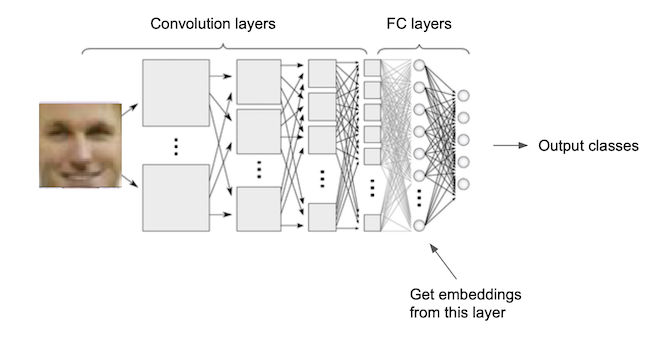



---
<a id='visual_distributions'></a>
## Содержание

- [⚒ Подготовка окружения](#environment)

- [📚 Подготовка данных](#data)

    - [💾 Загрузка данных](#download)

    - [🖼 Визуализация изображений](#visuaL)

    - [⛓ Dataset & Dataloader](#dataloader)

- [⚙ Построение и обучение модели](#build_train)

    - [🏎 Inception Resnet V1](#inception)

    - [🧠 Обучение модели](#train)
    
- [📊 Cosine Similarity Distribution](#csd)

    - [🔢 Matrix of Cosine Similarity](#mcs)
    
- [ 📈 Identification Rate Metric](#irm)

<a id='environment'></a>
## ⚒ Подготовка окружения
Импортируем необходимые библиотеки

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pandas as pd
import random
import copy
from tqdm import tqdm
import torchsummary
import os
import pickle
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

Вычисления будем проводить на GPU

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(DEVICE)
!nvidia-smi

cuda
Sun Jan 30 17:50:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

Далее будем сохранять лучшие модели на Google Диск

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DIR = '/content/gdrive/MyDrive/faceRec'

<a id='data'></a>
## 📚 Подготовка данных

В качестве обучающей выборки возьмем часть датасета [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Далее мы будем использовать его версию, в которой все изображения выровнены и обрезаны. Этот набор данных можно скачать по [ссылке](https://disk.yandex.ru/d/FVFucEDrZaxI9g).

<a id='download'></a>
### 💾 Загрузка данных

In [ ]:
# Эта ссылка не будет работать для вас. Если вы хотите сгенерировать рабочую ссылку,
# посетите https://askubuntu.com/questions/1188381/how-to-get-link-of-file-to-download-with-wget
# или скачайте данные и поместите их в папку вручную
! wget "https://s765sas.storage.yandex.net/rdisk/36f14fddc3de6a8bf0547d156945b443c4d91b56eaa1f9225ce7469cb05777fd/61f6ef19/aZ8Akc9CqtcaAMvg9MkExb-ZXFJYNWenUWJ_dbR92U4Li0Fm9ILKkVrnJJYE3VZWsNkdU6Gc2QUgXQTMgBkqjw==?uid=0&filename=celebA_train_1k.zip&disposition=attachment&hash=PfmOewm6R2ULQcsn/YzTYJAc1RAPeCDt%2Bp28Gx92u6wDzG5HjZYUVPYC93xmi%2BwEq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=179856800&hid=f0124eac823ad5b8355d598606e9183d&media_type=compressed&tknv=v2&rtoken=oA9av8C6PiZ0&force_default=no&ycrid=na-f861054831487eac56eacecc0e1b84a9-downloader1f&ts=5d6d229d73840&s=ab22fd5733f0c40a883af7e333ba09ba19ab6e085c310ef3bee3c256ac54fba6&pb=U2FsdGVkX1-WeajwXBWHSV3TFryOHZ-4pDM-GnBexDcehhC8AXnz55Lf6JjyH4uyah2ABM9k8St5e9GMCwvn0t1QAwPaqhGDIJdNFIMqk40" - O celebA.zip
! unzip -q celebA.zip

Давайте посмотрим на данные:

In [ ]:
! ls celebA_train_1k/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — папка с выровненными изображениями 
- celebA_anno.txt — файл с аннотациями: какому человеку соответствует каждое изображение
- celebA_train_split.txt — файл с информацией о train/val/test

<a id='visuaL'></a>
### 🖼 Визуализация изображений

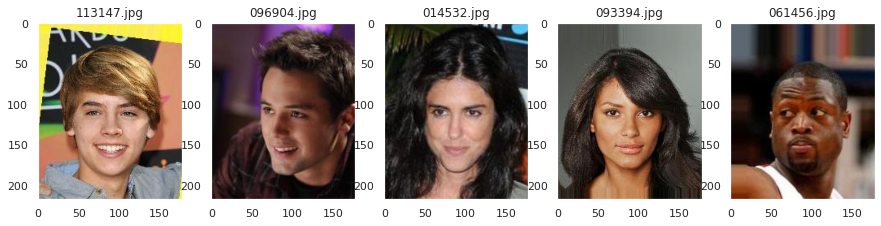

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join('celebA_train_1k/celebA_imgs/', img))
        imgs.append(np.array(img))

    f, axes = plt.subplots(1, len(imgs), figsize=(3*len(imgs), 5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i])
        axes[i].set_title(images_names[i])
        axes[i].grid(None)
    plt.show()


images_names = os.listdir('./celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)

<a id='dataloader'></a>
### ⛓ Dataset & Dataloader

In [ ]:
def get_paths(dataset_type='train'):
    '''
    функция, возвращающая список путей к изображениям для заданного типа набора данных
    параметры:
      dataset_type: одно из 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join(
            'celebA_train_1k/celebA_imgs/', filename))

    return np.array(images_paths)

Создадим Dataset'ы

In [ ]:
class celebADataset(Dataset):

    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()

        labels = [x.strip().split() for x in labels]
        labels = {x: int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
class FaceTransform:

    def __init__(self, im_size=0, y_frame=65, x_frame=35):
        self.im_size = im_size
        self.y_frame = y_frame
        self.x_frame = x_frame

    def __call__(self, x):
        # input size: 218 x 178
        im_size = self.im_size
        y_frame = self.y_frame
        x_frame = self.x_frame

        img = functional.crop(
            x, y_frame, x_frame, int(218-1.52*y_frame), 178-2*x_frame)
        if im_size:
            img = functional.resize(img, im_size)
        img = functional.to_tensor(img)
        img = functional.normalize(
            img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return img


transform = FaceTransform()

train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

Создадим Dataloader'ы

In [ ]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


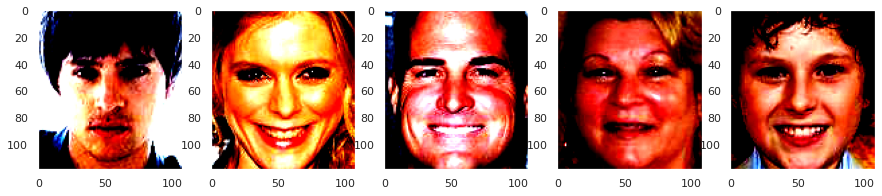

In [ ]:
num_img = 5
trans_img = np.rollaxis(next(iter(train_loader))[
                        'image'].numpy(), 1, 4)[:num_img]

f, axes = plt.subplots(1, 5, figsize=(3*5, 5))
for i, axis in enumerate(axes):
    axes[i].imshow(trans_img[i])
    axes[i].grid(None)
plt.show()

<a id='build_train'></a>
## ⚙ Построение и обучение модели

<a id='inception'></a>
### 🏎 Inception Resnet V1
Далее мы будем использовать предобученную на VGGFace2 сеть InceptionResnetV1: https://github.com/timesler/facenet-pytorch/tree/master/models

In [ ]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [ ]:
! ls models

inception_resnet_v1.py	mtcnn.py  utils


In [ ]:
from models import inception_resnet_v1

In [ ]:
model = inception_resnet_v1.InceptionResnetV1(
    pretrained='vggface2',
    classify=True, num_classes=1000
).to(DEVICE)

In [ ]:
torchsummary.summary(model, input_size=(3, 119, 108))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 43, 43]             864
       BatchNorm2d-2           [-1, 32, 43, 43]              64
              ReLU-3           [-1, 32, 43, 43]               0
       BasicConv2d-4           [-1, 32, 43, 43]               0
            Conv2d-5           [-1, 32, 41, 41]           9,216
       BatchNorm2d-6           [-1, 32, 41, 41]              64
              ReLU-7           [-1, 32, 41, 41]               0
       BasicConv2d-8           [-1, 32, 41, 41]               0
            Conv2d-9           [-1, 64, 41, 41]          18,432
      BatchNorm2d-10           [-1, 64, 41, 41]             128
             ReLU-11           [-1, 64, 41, 41]               0
      BasicConv2d-12           [-1, 64, 41, 41]               0
        MaxPool2d-13           [-1, 64, 20, 20]               0
           Conv2d-14           [-1, 80,

In [ ]:
child_counter = 0
for child in model.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
 child 1 is:
BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
 child 2 is:
BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 child 4 is:
BasicConv2d(
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
 child 5 is:
BasicConv2d(
  (conv): Conv2d(80, 192, kernel_size=(3, 3), strid

<a id='train'></a>
### 🧠 Обучение модели

Теперь мы будем файнтюнить эту сеть. Замораживаем Feature Extractor. Будем обучать только FC-часть

In [ ]:
for i, child in enumerate(model.children()):
    if i not in [14, 15, 16, 17]:
        for param in child.parameters():
            param.requires_grad = False

Функции для обучения сети

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for batch in train_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch in val_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [ ]:
def train(train_loader, val_loader, model, epochs,
          optimizer, scheduler, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(
                model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc,
                                           v_acc=val_acc))

    return history

In [ ]:
model = model.cuda()

В качестве функци потерь будем использовать CE. Для оценки качества работы модели будем рассчитывать accuracy на тестовых данных. 
В качестве оптимизатора будем использовать Adam, в качестве шедулера StepLR.

In [ ]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)
criterion = nn.CrossEntropyLoss()

In [ ]:
history = train(train_loader, val_loader, model, epochs,
                optimizer, scheduler, criterion)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 7.081466393034732


epoch:  10%|█         | 1/10 [00:55<08:23, 55.98s/it]


Epoch 001 train_loss: 7.0815     val_loss 4.3448 train_acc 0.0007 val_acc 0.4826
loss 4.417187061929999


epoch:  20%|██        | 2/10 [01:50<07:23, 55.40s/it]


Epoch 002 train_loss: 4.4172     val_loss 2.3624 train_acc 0.0691 val_acc 0.4727
loss 1.5104257652532291


epoch:  30%|███       | 3/10 [02:46<06:27, 55.29s/it]


Epoch 003 train_loss: 1.5104     val_loss 1.4818 train_acc 0.6548 val_acc 0.6876
loss 0.7059209006408041


epoch:  40%|████      | 4/10 [03:41<05:30, 55.16s/it]


Epoch 004 train_loss: 0.7059     val_loss 0.4749 train_acc 0.8617 val_acc 0.9151
loss 0.29497786327793507


epoch:  50%|█████     | 5/10 [04:35<04:35, 55.05s/it]


Epoch 005 train_loss: 0.2950     val_loss 0.4450 train_acc 0.9540 val_acc 0.9194
loss 0.22808044507626407


epoch:  60%|██████    | 6/10 [05:30<03:39, 54.99s/it]


Epoch 006 train_loss: 0.2281     val_loss 0.4350 train_acc 0.9686 val_acc 0.9186
loss 0.16614975793625678


epoch:  70%|███████   | 7/10 [06:25<02:44, 54.95s/it]


Epoch 007 train_loss: 0.1661     val_loss 0.4276 train_acc 0.9783 val_acc 0.9194
loss 0.14649406102366958


epoch:  80%|████████  | 8/10 [07:20<01:49, 54.98s/it]


Epoch 008 train_loss: 0.1465     val_loss 0.4262 train_acc 0.9834 val_acc 0.9186
loss 0.13149869654232574


epoch:  90%|█████████ | 9/10 [08:15<00:54, 54.93s/it]


Epoch 009 train_loss: 0.1315     val_loss 0.4268 train_acc 0.9860 val_acc 0.9197
loss 0.11125767237691782


epoch: 100%|██████████| 10/10 [09:10<00:00, 55.05s/it]


Epoch 010 train_loss: 0.1113     val_loss 0.4265 train_acc 0.9887 val_acc 0.9189


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

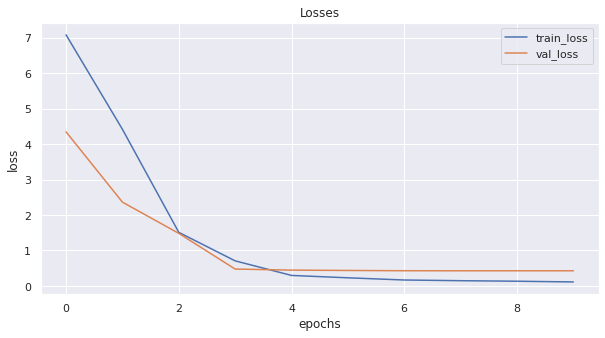

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.show()

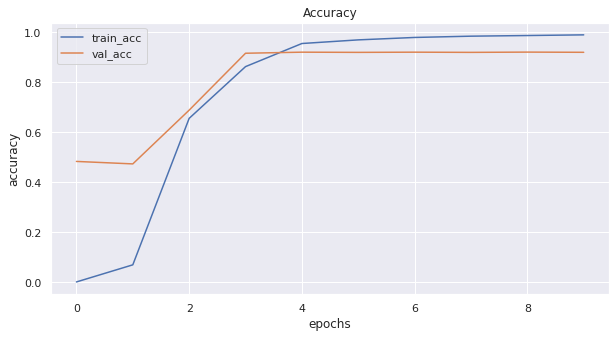

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.show()

In [ ]:
# Сохранить веса нейросети
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, DIR + '/model_weights.pth')

In [ ]:
# Загрузить веса нейросети
model.load_state_dict(torch.load(DIR + '/model_weights.pth'))

<All keys matched successfully>

In [ ]:
_, test_acc = eval_epoch(model, test_loader, criterion)
print(f'Test Accuracy: {test_acc:0.4f}')

Test Accuracy: 0.9093


Достаточно неплохой результат.

<a id='csd'></a>
## 📊 Cosine Similarity Distribution

Теперь сделаем следующее: 

* Отбросим последний слой обученной сети.

* Получим эмбеддинги для всех изображений из обучающего набора данных и для изображений из тестового набора.

* Вычислим все косинусные расстояния между эмбеддингами, соответствующими изображениям одного и того же человека в тестовом наборе данных и обучающем наборе данных.

* Вычислим косинусные расстояния для пар эмбеддингов, соответствующих разным людям.

* По полученным данным построим распределения косинусного расстояния и посмотрим, разделимы ли они?


In [ ]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
model_for_emb = inception_resnet_v1.InceptionResnetV1(
    pretrained='vggface2',
    classify=True, num_classes=1000
).to(DEVICE).cuda()

model_for_emb.load_state_dict(torch.load(DIR + '/model_weights.pth'))

<All keys matched successfully>

In [ ]:
def get_embeddings(model, data_loader):
    model.eval()
    model.logits = nn.Identity()
    embeddings = {}

    for batch in data_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        with torch.no_grad():
            outputs = model(inputs)
        for label, vector in zip(labels, outputs):
            label = int(label)
            if label in embeddings:
                embeddings[label] = torch.cat((embeddings[label], vector))
            else:
                embeddings[label] = vector

    for label in embeddings.keys():
        embeddings[label] = embeddings[label].view(-1, 512)

    return embeddings

In [ ]:
train_embeddings = get_embeddings(model_for_emb, train_loader)
test_embeddings = get_embeddings(model_for_emb, test_loader)

In [ ]:
len(train_embeddings), len(test_embeddings)

(1000, 976)

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(DIR, 'train_embeddings.pickle'), 'wb') as f:
    pickle.dump(train_embeddings, f)

with open(os.path.join(DIR, 'test_embeddings.pickle'), 'wb') as f:
    pickle.dump(test_embeddings, f)

In [ ]:
# Загрузим векторы
with open(os.path.join(DIR, 'train_embeddings.pickle'), 'rb') as f:
    train_embeddings = pickle.load(f)

with open(os.path.join(DIR, 'test_embeddings.pickle'), 'rb') as f:
    test_embeddings = pickle.load(f)

In [ ]:
positive_cos_train = torch.tensor(()).to(DEVICE)
for label in train_embeddings.keys():
    num_vec = train_embeddings[label].shape[0]
    if num_vec > 1:
        for i in range(num_vec):
            for j in range(num_vec):
                if j > i:
                    cos_sim = F.cosine_similarity(
                        train_embeddings[label][i],
                        train_embeddings[label][j],
                        dim=-1)
                    positive_cos_train = torch.hstack(
                        (positive_cos_train, cos_sim))

In [ ]:
positive_cos_test = torch.tensor(()).to(DEVICE)
for label in test_embeddings.keys():
    num_vec = test_embeddings[label].shape[0]
    if num_vec > 1:
        for i in range(num_vec):
            for j in range(num_vec):
                if j > i:
                    cos_sim = F.cosine_similarity(
                        test_embeddings[label][i],
                        test_embeddings[label][j],
                        dim=-1)
                    positive_cos_test = torch.hstack(
                        (positive_cos_test, cos_sim))

In [ ]:
k = 0
KMAX = 1e5
negative_cos_test = torch.tensor(()).to(DEVICE)

for label1 in test_embeddings.keys():
    num_vec1 = test_embeddings[label1].shape[0]

    for label2 in test_embeddings.keys():
        num_vec2 = test_embeddings[label2].shape[0]

        if (label1 < label2) and (k < KMAX):
            for i in range(num_vec1):
                for j in range(num_vec2):
                    cos_sim = F.cosine_similarity(
                        test_embeddings[label1][i],
                        test_embeddings[label2][j],
                        dim=-1)
                    negative_cos_test = torch.hstack(
                        (negative_cos_test, cos_sim))
                    k += 1

In [ ]:
k = 0
KMAX = 1e5
negative_cos_train = torch.tensor(()).to(DEVICE)

for label1 in train_embeddings.keys():
    num_vec1 = train_embeddings[label1].shape[0]

    for label2 in train_embeddings.keys():
        num_vec2 = train_embeddings[label2].shape[0]

        if (label1 < label2) and (k < KMAX):
            for i in range(num_vec1):
                for j in range(num_vec2):
                    cos_sim = F.cosine_similarity(
                        train_embeddings[label1][i],
                        train_embeddings[label2][j],
                        dim=-1)
                    negative_cos_train = torch.hstack(
                        (negative_cos_train, cos_sim))
                    k += 1

In [ ]:
# Запишем в словарь
with open(os.path.join(DIR, 'positive_cos_train.pickle'), 'wb') as f:
    pickle.dump(positive_cos_train, f)

with open(os.path.join(DIR, 'positive_cos_test.pickle'), 'wb') as f:
    pickle.dump(positive_cos_test, f)

with open(os.path.join(DIR, 'negative_cos_train.pickle'), 'wb') as f:
    pickle.dump(negative_cos_train, f)

with open(os.path.join(DIR, 'negative_cos_test.pickle'), 'wb') as f:
    pickle.dump(negative_cos_test, f)

In [ ]:
# Загрузим
with open(os.path.join(DIR, 'positive_cos_train.pickle'), 'rb') as f:
    positive_cos_train = pickle.load(f)

with open(os.path.join(DIR, 'positive_cos_test.pickle'), 'rb') as f:
    positive_cos_test = pickle.load(f)

with open(os.path.join(DIR, 'negative_cos_train.pickle'), 'rb') as f:
    negative_cos_train = pickle.load(f)

with open(os.path.join(DIR, 'negative_cos_test.pickle'), 'rb') as f:
    negative_cos_test = pickle.load(f)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


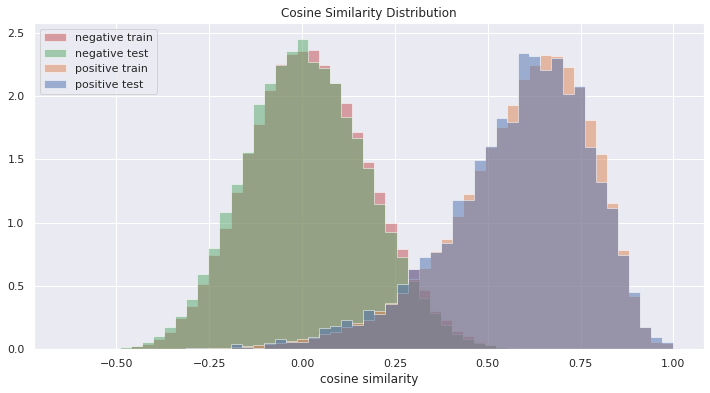

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist([
    positive_cos_test.cpu().numpy(),
    positive_cos_train.cpu().numpy(),
    negative_cos_test.cpu().numpy(),
    negative_cos_train.cpu().numpy(),
],
    bins=55, density=True, histtype='stepfilled', alpha=0.5,
    label=['positive test', 'positive train',
           'negative test', 'negative train'])
plt.legend(loc='upper left')
plt.xlabel("cosine similarity")
plt.title('Cosine Similarity Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


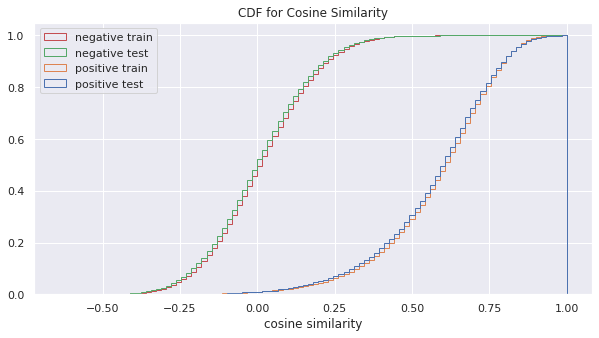

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist([
    positive_cos_test.cpu().numpy(),
    positive_cos_train.cpu().numpy(),
    negative_cos_test.cpu().numpy(),
    negative_cos_train.cpu().numpy(),
],
    bins=100, density=True, histtype='step', alpha=1,
    label=['positive test', 'positive train',
           'negative test', 'negative train'], cumulative=True,)
plt.legend(loc='upper left')
plt.xlabel("cosine similarity")
plt.title('CDF for Cosine Similarity')
plt.show()

Видим, что можно подобрать такое пороговое значение косинусного расстояния, при котором с некоторой точностью получившиеся распределения будут разделимы.

<a id='mcs'></a>
### 🔢 Matrix of Cosine Similarity

Построим матрицу косинусных расстояний между различными людьми в трейне и тесте

In [ ]:
def get_mean_embeddings(embeddings):

    for label in embeddings.keys():
        embeddings[label] = embeddings[label].view(-1, 512).mean(dim=0)

    return embeddings

In [ ]:
train_mean_embeddings = get_mean_embeddings(train_embeddings)
test_mean_embeddings = get_mean_embeddings(test_embeddings)

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(DIR, 'train_mean_embeddings.pickle'), 'wb') as f:
    pickle.dump(train_mean_embeddings, f)

with open(os.path.join(DIR, 'test_mean_embeddings.pickle'), 'wb') as f:
    pickle.dump(test_mean_embeddings, f)

In [ ]:
# Загрузим векторы
with open(os.path.join(DIR, 'train_mean_embeddings.pickle'), 'rb') as f:
    train_mean_embeddings = pickle.load(f)

with open(os.path.join(DIR, 'test_mean_embeddings.pickle'), 'rb') as f:
    test_mean_embeddings = pickle.load(f)

In [ ]:
overlap_keys = train_embeddings.keys() & test_embeddings.keys()

len(overlap_keys)

976

In [ ]:
new_train_emb = torch.tensor(()).to(DEVICE)
new_test_emb = torch.tensor(()).to(DEVICE)

for label in overlap_keys:
    new_train_emb = torch.cat((new_train_emb, train_embeddings[label]), dim=-1)
    new_test_emb = torch.cat((new_test_emb, test_embeddings[label]), dim=-1)

new_train_emb = new_train_emb.view(-1, 512)
new_test_emb = new_test_emb.view(-1, 512)

In [ ]:
cos_sim_matrix = cosine_similarity(new_train_emb.cpu(), new_test_emb.cpu())
cos_sim_matrix.shape

(976, 976)

In [ ]:
# Запишем матрицу в словарь
with open(os.path.join(DIR, 'cos_sim_matrix.pickle'), 'wb') as f:
    pickle.dump(cos_sim_matrix, f)

In [ ]:
# Загрузим матрицу
with open(os.path.join(DIR, 'cos_sim_matrix.pickle'), 'rb') as f:
    cos_sim_matrix = pickle.load(f)

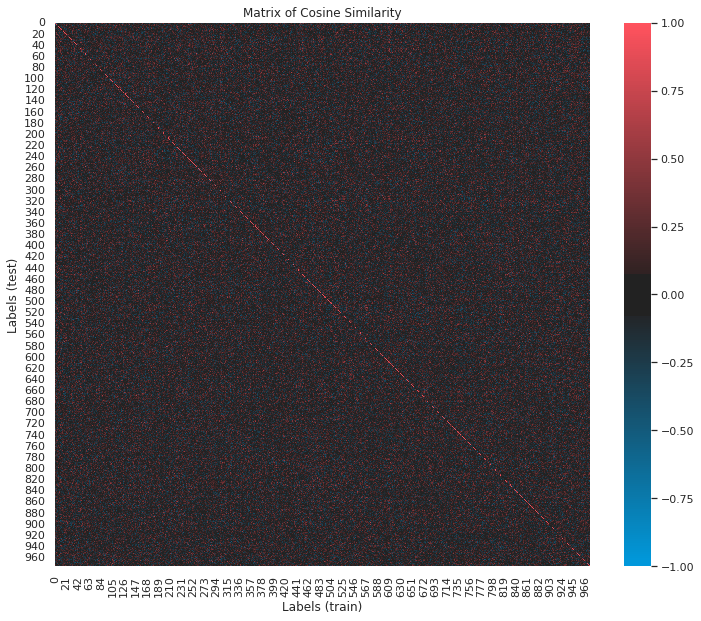

In [ ]:
my_p = sns.diverging_palette(240, 10, s=100, sep=20, l=60,
                             center="dark", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cos_sim_matrix, cmap=my_p, vmin=-1, vmax=1)
plt.xlabel("Labels (train)")
plt.ylabel("Labels (test)")
plt.title('Matrix of Cosine Similarity')
plt.show(fig)

<a id='irm'></a>
## 📈 Identification Rate Metric
При обучении модели выше мы использовали accuracy на валидационных данных в качестве меры производительности нашей модели. Однако у этого метода есть существенный недостаток: мы не можем измерить, насколько хорошо модель будет работать на неизвестных ей лицах (которых нет в тренировочном, валидационном и тестовом наборах данных).

Чтобы решить эту проблему, мы можем рассчитать другую метрику для модели:  **identification rate**. Вот как она работает:

У нас есть два набора лиц: query и distractors. Ни одно лицо из этих наборов не присутствует в обучающем, валидационном или тестовом наборах.

1. Вычислияем косинусное сходство между всеми лицами, соответствующими одним и тем же людям из набора данных query. Это означает, что если у человека есть 3 фотографии в query: 01.jpg, 02.jpg, 03.jpg, то вычисляется 3 косинусных сходства между каждой парой эмбеддингов, соответствующих этим фотографиям.

2. Вычислияем косинусное сходство между всеми лицами, соответствующими разным людям из набора данных query.

3. Вычислияем косинусное сходство между всеми парами эмбеддингов, соответствующих query и distractors. То есть считаем cosine similarity между парами (q, d), где q - эбмеддинг, соответствующий лицу из query, d - эбмеддинг, соответствующий лицу из distractors. Мы получим сходство |query|*|distractors|.

4. Складываем количество сходств из 2 и 3 пунктов. Это количество ложных пар (false pairs).

5. Фиксируем **FPR** (false positive rate, коэффициент ложных срабатываний). Пусть в нашем случае он будет равен 0.01. FPR, умноженное на количество ложных пар из пункта 4, - это количество ложных срабатываний, которые мы допускаем в нашей модели. Назовем это число N

6. Отсортируем все similarity ложных пар в порядке убывания. Получим N-й элемент от начала - это наше пороговое сходство (**threshold similarity**).

7. Подсчитаем, сколько positive similarities из пункта 1 равно или больше threshold similarity. Разделим это число на целое число positive similarities из пункта 1. Это и есть TPR (true positive rate) - наша метрика.

Эта метрика также может записываться как TPR@FPR=0.01. FPR может варьироваться.

Наборы данных (query фотографии, метки query и distructors фотографии) можно скачать здесь: https://disk.yandex.ru/d/C54mClLmQkag6Q

In [ ]:
! wget "https://s339vla.storage.yandex.net/rdisk/840835033d0b307c9ddca355b61f0365a7d47ab7d5923aca91a407266135c757/61f7019f/aZ8Akc9CqtcaAMvg9MkExUS0nM-Qw6vBjH2cBgsvJt4L8iF-6XTumJI9B01yJilqrXxNRYEGr_S1T7X9_fQXiQ==?uid=0&filename=celebA_ir.zip&disposition=attachment&hash=MCgzRvhQiUJarz9o08OG/sEcpdPhcvZdM1R/Ra2e2NF0ybsUoL/BrSQw424Y62pLq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=75566735&hid=5e690094946e8e9da28436cde7a2724a&media_type=compressed&tknv=v2&rtoken=QVP0j4T0KxmF&force_default=no&ycrid=na-90b49bda1cbbe11a6f1aef588f396299-downloader20e&ts=5d6d3447c65c0&s=53a09bc18ecbc09f66f4138298a758f5eb9f16aa6d9936cb150e8de04e48812d&pb=U2FsdGVkX1_eBQv5zAHuIrD90R8355tl8t8oknIpn875b2am9rrnVX5-lriwWga5H4OpQHWGivQ6SpF1ZnlfhwLMannjEBh440Ml08ziy5M" - O celebA_ir.zip
! unzip celebA_ir.zip

In [ ]:
! ls celebA_ir/

celebA_anno_query.txt  celebA_distractors  celebA_query


In [ ]:
# файл с аннотациями к query части: какое изображение относится к какому классу
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]
# список названий изображений из query
query_img_names = [x[0] for x in query_lines]

# словарь с информацией о том, какие изображения из query относятся к какому классу
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# список названий distractor изображений
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

Загрузим обученную модель

In [ ]:
model = inception_resnet_v1.InceptionResnetV1(
    pretrained='vggface2',
    classify=True, num_classes=1000
).to(DEVICE)

model.load_state_dict(torch.load(DIR + '/model_weights.pth'))

<All keys matched successfully>

In [ ]:
def compute_embeddings(model, images_list, dataset_type='query'):
    '''
    вычислить эмбеддинги из обученной модели для списка изображений.
    параметры:
        model: обученная nn, которая принимает изображения и выдает эмбеддинги
        images_list: список путей изображений для вычисления эмбеддингов
    output:
        tensor: тензор из эмбеддингов модели. Каждому эмбеддингу соответствуют 
                изображения с именами из списка images_list
    '''

    model_embed = model
    model_embed.logits = nn.Identity()
    model_embed.eval()
    embeddings = []

    resize = transforms.Resize((119, 108))

    dir = './celebA_ir/celebA_' + dataset_type + '/'
    for img_name in images_list:
        img = np.array(Image.open(os.path.join(dir, img_name)))
        input = resize(torch.FloatTensor(
            np.rollaxis(img, 2, 0))).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model_embed(input)
        embeddings.append(output)

    return embeddings

In [ ]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(
    model, distractors_img_names, 'distractors')

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(DIR, 'query_embeddings.pickle'), 'wb') as f:
    pickle.dump(query_embeddings, f)

with open(os.path.join(DIR, 'distractors_embeddings.pickle'), 'wb') as f:
    pickle.dump(distractors_embeddings, f)

In [ ]:
# Загрузим векторы
with open(os.path.join(DIR, 'query_embeddings.pickle'), 'rb') as f:
    query_embeddings = pickle.load(f)

with open(os.path.join(DIR, 'distractors_embeddings.pickle'), 'rb') as f:
    distractors_embeddings = pickle.load(f)

In [ ]:
len(query_embeddings), len(distractors_embeddings)

(7198, 23397)

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    вычислить косинусное сходство между положительными парами из query (пункт 1)
    параметры:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: класс
            в датасете. Value: изображения, соответствующие данному классу
        query_img_names: список названий изображений
        query_embeddings: список эмбеддингов, соответствующих query_img_names
    output:
        list of floats: косинусное сходство между эмбеддингами, соответствующими
            одним и тем же людям из списка query
    '''
    dict_name_emb = {name: emb for name, emb in zip(
        query_img_names, query_embeddings)}
    cosine_query_pos = torch.tensor(()).to(DEVICE)
    for label in query_dict.keys():
        num_vec = len(query_dict[label])
        if num_vec > 1:
            for i, iname in enumerate(query_dict[label]):
                for j, jname in enumerate(query_dict[label]):
                    if j > i:
                        cos_sim = F.cosine_similarity(
                            dict_name_emb[iname],
                            dict_name_emb[jname],
                            dim=-1)

                        cosine_query_pos = torch.hstack(
                            (cosine_query_pos, cos_sim))

    return cosine_query_pos.tolist()

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)

In [ ]:
len(cosine_query_pos)

88952

In [ ]:
# Сохраним
with open(os.path.join(DIR, 'cosine_query_pos.pickle'), 'wb') as f:
    pickle.dump(cosine_query_pos, f)

In [ ]:
# Загрузим
with open(os.path.join(DIR, 'cosine_query_pos.pickle'), 'rb') as f:
    cosine_query_pos = pickle.load(f)

In [ ]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    вычислить косинусное сходство между negative pairs из query (пункт 2)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: класс 
            в датасете. Value: изображения, соответствующие данному классу
        query_img_names: список названий изображений
        query_embeddings: список эбмеддингов, соответствующих query_img_names
    output:
        list of floats: сходство между эмбеддингами, соответствующими разным
                        людям из списка query
    '''
    query_copy = query_dict.copy()
    if 'query_dict' in query_copy:
        query_copy.pop('query_dict')
    query = {}
    for label in query_copy.keys():
        for name_img in query_copy[label]:
            query[name_img] = int(label)

    mask = np.zeros((len(query_img_names), len(query_img_names)))

    for i, label1 in enumerate(query_img_names):
        for j, label2 in enumerate(query_img_names):
            if query[label1] > query[label2]:
                mask[i][j] = 1

    cosines = cosine_similarity(query_embeddings.cpu())

    cosine_query_neg = cosines * mask

    return cosine_query_neg[cosine_query_neg.nonzero()]

In [ ]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            torch.cat(query_embeddings))

In [ ]:
len(cosine_query_neg)

25813051

In [ ]:
# Сохраним
with open(os.path.join(DIR, 'cosine_query_neg.pickle'), 'wb') as f:
    pickle.dump(cosine_query_neg, f)

In [ ]:
# Загрузим
with open(os.path.join(DIR, 'cosine_query_neg.pickle'), 'rb') as f:
    cosine_query_neg = pickle.load(f)

In [ ]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    вычислить косинусное сходство между negative pairs из query и distractors (пункт 3)
    params:
        query_embeddings: список эмбеддингов, соответствующих query_img_names
        distractors_embeddings: список эмбеддингов, соответствующих distractors_img_names
    output:
        list of floats: сходство между парами людей (q, d), где
                        q - эмбеддинг, соответствующий фотографии из query, 
                        d — эмбеддинг, соответствующий фотографии из distractors
    '''

    cosine_query_distractors = cosine_similarity(
        query_embeddings.cpu(), distractors_embeddings.cpu())

    return cosine_query_distractors.flatten()

In [ ]:
cosine_query_distractors = compute_cosine_query_distractors(
    torch.cat(query_embeddings), torch.cat(distractors_embeddings))

In [ ]:
cosine_query_distractors.shape

(168411606,)

In [ ]:
# Сохраним
with open(os.path.join(DIR, 'cosine_query_distractors.pickle'), 'wb') as f:
    pickle.dump(cosine_query_distractors, f)

In [ ]:
# Загрузим
with open(os.path.join(DIR, 'cosine_query_distractors.pickle'), 'rb') as f:
    cosine_query_distractors = pickle.load(f)

**Тесты**

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.tensor((
    (1.56, 6.45,  -7.68),
    (-1.1, 6.11,  -3.0),
    (-0.06, -0.98, -1.29),
    (8.56, 1.45,  1.11),
    (0.7,  1.1,   -7.56),
    (0.05, 0.9,   -2.56),)
).to(DEVICE)

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.tensor((
    (0.12, -3.23, -5.55),
    (-1,   -0.01, 1.22),
    (0.06, -0.23, 1.34),
    (-6.6, 1.45,  -1.45),
    (0.89,  1.98, 1.45),)
).to(DEVICE)

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                                 test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                                 test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                                 test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
    "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
    "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042, -0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
    "A mistake in compute_cosine_query_distractors function"

Имплементируем финальную функцию: расчет identification rate

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    вычисление identification rate с использованием заранее расчитанных косинусных
    сходств между парами при заданном fpr
    params:
        cosine_query_pos: косинусное сходство между positive парами из query
        cosine_query_neg: косинусное сходство между negative парами из query
        cosine_query_distractors: косинусное сходство между negative парами 
                                из query и distractors
        fpr: false positive rate, при котором вычисляется TPR
    output: 
        float: threshold для заданного fpr 
        float: TPR при заданном FPR
    '''
    num_false_pairs = len(cosine_query_neg) + len(cosine_query_distractors)
    num_false_positives = int(fpr * num_false_pairs)  # N

    all_sim_false_pairs = np.sort(np.concatenate(
        (cosine_query_neg,
         cosine_query_distractors)))[::-1]

    threshold_similarity = all_sim_false_pairs[num_false_positives]

    tpr = np.sum(cosine_query_pos >= threshold_similarity) / \
        len(cosine_query_pos)

    return threshold_similarity, tpr

**Тест:**

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                      test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)
                   ), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(
    true_tpr)), "A mistake in computing tpr"

Наконец, вычислим tpr для набора данных с query и distractors при различных fpr

In [ ]:
thr = []
tpr = []
fpr_list = np.linspace(0, 0.99999, 30)

for fpr in fpr_list:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                      cosine_query_distractors, fpr=fpr)
    thr.append(x)
    tpr.append(y)

In [ ]:
# Сохраним
with open(os.path.join(DIR, 'thr.pickle'), 'wb') as f:
    pickle.dump(thr, f)

with open(os.path.join(DIR, 'tpr.pickle'), 'wb') as f:
    pickle.dump(tpr, f)

In [ ]:
# Загрузим
with open(os.path.join(DIR, 'thr.pickle'), 'rb') as f:
    thr = pickle.load(f)

with open(os.path.join(DIR, 'tpr.pickle'), 'rb') as f:
    tpr = pickle.load(f)

In [ ]:
tpr_dataframe = pd.DataFrame(
    {"Thresholder": thr,
     "True positive rate": tpr,
     "False positive rate": fpr_list
     }
)
tpr_dataframe

,Thresholder,True positive rate,False positive rate
0,0.999422,0.000124,0.000000
1,0.979279,0.116883,0.034482
2,0.973680,0.178107,0.068965
3,0.969093,0.228831,0.103447
4,0.964925,0.274137,0.137930
5,0.960956,0.316474,0.172412
6,0.957073,0.356349,0.206894
7,0.953210,0.393785,0.241377
8,0.949311,0.428557,0.275859
9,0.945338,0.463104,0.310342


In [ ]:
print(f'ROC-AUC: {fpr_list[1] * tpr_dataframe["True positive rate"].sum():.2f}')

ROC-AUC: 0.62


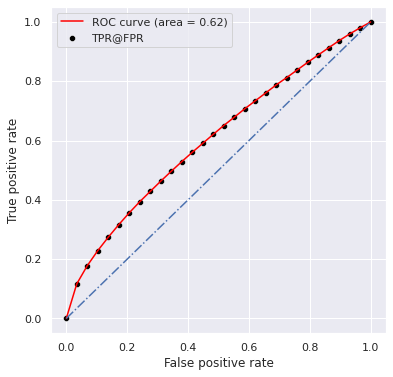

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(tpr_dataframe["False positive rate"],
         tpr_dataframe["True positive rate"],
         color='red', linestyle='-')
sns.scatterplot(data=tpr_dataframe,
                x="False positive rate",
                y="True positive rate",
                palette='orange', color='black')
plt.legend(['ROC curve (area = 0.62)', 'TPR@FPR'])
plt.plot(fpr_list, fpr_list, linestyle='-.')
plt.show()

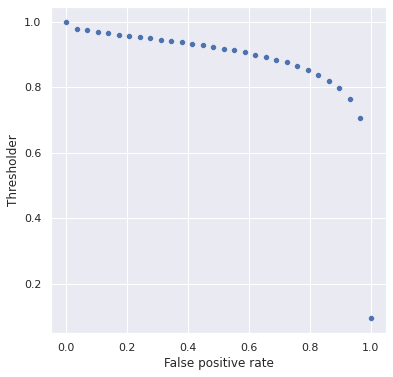

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=tpr_dataframe, x="False positive rate", y="Thresholder")
plt.show()